In [75]:
import numpy as np
import pandas as pd
import os,glob,re
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import palettable
from scipy.stats import skewnorm, rv_histogram
import scipy.stats as sps

In [99]:
pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='error', category=FutureWarning)

In [77]:
colors = ('#284E60', '#E1A730', '#D95980', '#C3B1E1', '#351F27', '#A9C961')
clr_truth = 'dimgray'

### `climo_to_df(file)`
This script reads in the TCANE climatology files and saves the output to a `Pandas` DataFrame. 

<b>Inputs</b>:
* `file`: name of file to read into dataframe [str]

<b>Outputs</b>: 
* `df_clim`: contents of `file` converted to `Pandas` DataFrame [DataFrame]

In [78]:
def climo_to_df(file):
    with open(file) as f:
        col_headers = f.readline().split()
    #
    with open(file, 'r') as fp:
        for count, line in enumerate(fp):
            pass
    #
    df_clim = pd.DataFrame(columns=col_headers,index=np.arange(0,count))
    #
    with open(file,'r') as fi:
        fen = fi.readlines()
        for i in np.arange(1,count+1):
            fline = fen[i].split()
            df_clim.loc[i-1,:] = fline
    #
    df_clim.iloc[:,3:-1] = df_clim.iloc[:,3:-1].astype('float')
    df_clim = df_clim.mask(df_clim == -9999.0)
    df_clim['FHOUR'] = df_clim['FHOUR'].astype('int')
    return df_clim

### `read_in_TCANE(filename)`
This script reads in TCANE output files from the `.dat` format and saves the contents to a `Pandas` DataFrame. 

<b>Inputs</b>:
* `file`: name of file to read into Dataframe [str]

<b>Outputs</b>: 
* `df`: contents of `file` converted to `Pandas` DataFrame [DataFrame]

In [79]:
def read_in_TCANE(filename):
    # Get column headers
    with open(filename) as f:
        col_headers = f.readline().split()
    # Get number of lines in file
    with open(filename,'r') as fp:
        for count,line in enumerate(fp):
            pass
    # Make dataframe
    df = pd.DataFrame(columns=col_headers,index=np.arange(0,count))
    with open(filename,'r') as fi:
        fen = fi.readlines()
        for i in np.arange(1,count+1):
            fline = fen[i].split()
            df.loc[i-1,:] = fline
    # Make a date column
    df['FHOUR'] = df['FHOUR'].astype('int')
    df['DATE'] = pd.to_datetime(df['YEAR']+df['MMDDHH'],format='%Y%m%d%H')
    return df

### `get_TCANE_distribution_intensity (df,ttype_sel,df_in)`
This script reads in TCANE output files from the `.dat` format and saves the contents to a `Pandas` DataFrame. 

<b>Inputs</b>:
* `file`: name of file to read into Dataframe [str]

<b>Outputs</b>: 
* `df_tcdist`: `Pandas` DataFrame that contains the `mu`, `sigma`, `gamma`, and `tau` variables from the TCANE files [DataFrame]

In [80]:
def get_TCANE_distribution(df,ttype_sel,df_in):
    dfx = df.set_index(['TTYPE','FHOUR']).xs(ttype_sel)
    dfi = df_in.set_index(['FHOUR'])
    df_tcdist = pd.DataFrame(index=dfx.index,columns=['DIST','TTYPE'])
    for ihr in dfx.index:
        if ihr not in dfi.index:
            continue
        dist_tcane = [dfx.loc[ihr]['MU'] + dfi.loc[ihr]['VMAXN'], dfx.loc[ihr]['SIGMA'], dfx.loc[ihr]['GAMMA'], dfx.loc[ihr]['TAU']]
        df_tcdist.loc[ihr]['DIST'] = dist_tcane
        df_tcdist.loc[ihr]['TTYPE'] = ttype_sel
    return df_tcdist

### `get_TCANE_PDF_CDF(x,tcane_dist)`

This script reads in the distribution parameters from TCANE output files and recreates a distribution using those parameters. 

In [81]:
def get_TCANE_PDF_CDF(x,tcane_dist):
    for ihr in tcane_dist.index:
        dist = tcane_dist.loc[ihr]
        df_pdf = pd.DataFrame(columns=['PDF','CDF','FHOUR'],index=np.arange(0,len(x)))
        if ((np.size(dist['DIST']) == 1)):
            if (np.isnan(dist['DIST'])):
                df_pdf['FHOUR'] = ihr
                df_pdf['PDF'] = np.nan
                df_pdf['CDF'] = np.nan
        else:
            # 
            Z = sps.norm.rvs(size=len(x))
            Y = dist['DIST'][0] + dist['DIST'][1] * np.sinh((np.arcsinh(Z) + dist['DIST'][2]) / dist['DIST'][3])
            pdf_tcane = skewnorm.pdf(x,dist['DIST'][2],dist['DIST'][0],dist['DIST'][1])
            cdf_tcane = skewnorm.cdf(x,dist['DIST'][2],dist['DIST'][0],dist['DIST'][1])
            df_pdf['FHOUR'] = ihr
            df_pdf['PDF'] = pdf_tcane
            df_pdf['CDF'] = cdf_tcane
            #
            # df_alt['FHOUR'] = ihr
            # df_alt
        if ihr == tcane_dist.index[0]:
            pdf_ALL = df_pdf.copy()
            # pdf_alt = df_pdf.co
        else:
            pdf_ALL = pd.concat([pdf_ALL,df_pdf])
    return pdf_ALL

### `get_RI_info(pdf,x_in,ttype)`

In [82]:
def get_RI_info(pdf,x_in,ttype):
    RI_thresh = {12:20,
             24:30,
             36:45,
             48:55,
             72:65}
    TC_thresh = {1:64,
             2:83,
             3:96,
             4:113,
             5:137}
    ##
    for i in RI_thresh.keys():
        RI_prob = pd.DataFrame(columns=['TTYPE','PCT RI','RI THRESH'],index=[i])
        #
        foo = pdf[pdf['FHOUR']==i]
        thresh = x_in.set_index(['FHOUR']).xs(i)['VMAX0']+RI_thresh[i]
        pct_RI = (1-foo.loc[thresh]['CDF'])*100
        RI_prob['TTYPE'] = ttype
        RI_prob['PCT RI'] = pct_RI
        RI_prob['RI THRESH'] = thresh
        #
        if i == list(RI_thresh.keys())[0]:
            RI_all = RI_prob
        else:
            RI_all = pd.concat([RI_all,RI_prob])
    # Put into cats
    hrs = pdf['FHOUR'].unique().tolist()
    df_thresh = pd.DataFrame(columns=['TTYPE','PCT Cat1','PCT Cat2','PCT Cat3','PCT Cat4','PCT Cat5'],index=hrs)
    for ihr in hrs:
        ihfoo = pdf[pdf['FHOUR']==ihr]
        thresh = [TC_thresh[i] for i in TC_thresh.keys()]
        pct_RI = (1-ihfoo.loc[[y for y in thresh]]['CDF'])*100
        df_thresh['TTYPE'] = ttype
        df_thresh.loc[ihr,['PCT Cat1','PCT Cat2','PCT Cat3','PCT Cat4','PCT Cat5']] = pct_RI.values
    return RI_all,df_thresh

### `get_boxplot_info`

In [83]:
def get_boxplot_info(dist,X_in,ttype,nrv=1000):
    for ihr in dist.index:
        df_box = pd.DataFrame(columns=['DATA','TTYPE','FHOUR'],index=np.arange(0,nrv))
        if (ihr == 0) | (dist.loc[ihr].isnull().values.sum() > 0):
            df_box['DATA'] = X_in['VMAX0']
            df_box['FHOUR'] = ihr
            df_box['TTYPE'] = ttype
        else:
            xtest = dist.loc[ihr]
            dskn = skewnorm(xtest['DIST'][2],xtest['DIST'][0],xtest['DIST'][1]).rvs(nrv)
            df_box['DATA'] = dskn
            df_box['FHOUR'] = ihr
            df_box['TTYPE'] = ttype
        if ihr == dist.index[0]:
            df_box_ALL = df_box
        else:
            df_box_ALL = pd.concat([df_box_ALL,df_box])
    #
    return df_box_ALL

### `get_pctiles(dist)`

In [84]:
def get_pctiles(dist,ttype):
    for ihr in dist.index:
        df_pct = pd.DataFrame(columns=['P1','P10','P90','P99','P95','P5','P50','P25','P75','TTYPE'],index=[ihr])
        if (ihr == 0) | (dist.loc[ihr].isnull().values.sum() > 0):
            df_pct['TTYPE'] = ttype
        else:
            xtest = dist.loc[ihr]
            dd = skewnorm(xtest['DIST'][2],xtest['DIST'][0],xtest['DIST'][1])
            df_pct['P1'] = dd.ppf(.01)
            df_pct['P5'] = dd.ppf(.05)
            df_pct['P10'] = dd.ppf(.10)
            df_pct['P90'] = dd.ppf(.90)
            df_pct['P95'] = dd.ppf(.95)
            df_pct['P99'] = dd.ppf(.99)
            df_pct['P50'] = dd.ppf(.50)
            df_pct['P25'] = dd.ppf(.25)
            df_pct['P75'] = dd.ppf(.75)
            df_pct['TTYPE'] = ttype
        if ihr == dist.index[0]:
            df_pct_ALL = df_pct
        else:
            df_pct_ALL = pd.concat([df_pct_ALL,df_pct])
    return df_pct_ALL

### `get_bdecks(year,stormno,basin,bdeck_dir)`

This function gets the best track files for a given storm, identified by `year`, `stormno`, and `basin`. 

<b>Inputs</b>:
* `year`: year of desired storm
* `stormno`: number of desired storm (01-49, starts over again every year) [str]
* `basin`: basin where storm is located (2 characters) [str]
* `bdeck_dir`: directory where bdeck files are located [str]

<b>Outputs</b>:
* `b_deck_ALL`: Dataframe with all best track information [Dataframe]
* `b_deck_trim`: same as above, but trimmed to only identifying information and `VMAX` and `MSLP` [Dataframe]

In [85]:
def get_bdecks(year,stormno,basin,bdeck_dir):
    # Create appropriate filename
    if (basin == 'AL')|(basin == 'EP'):
        bas_dir = 'NHC'
    else:
        bas_dir = 'DOD'
    bd_dir_full = bdeck_dir#+'{bas_dir}/'.format(bas_dir=bas_dir)
    fpath_full = bd_dir_full+'b{basin}{stormno}{yr}.dat'.format(basin=basin.lower(),stormno=stormno,yr=year)
    if not os.path.exists(fpath_full):
        b_deck_ALL = pd.DataFrame()
        bdeck_trim = pd.DataFrame()
    else:
        # Set up empty dataframe
        b_deck_ALL = pd.DataFrame()
        fnames_all = [fpath_full]
        # 
        i_bdeck = pd.DataFrame()
        # For each file, read in best-track information from text file
        for i_line in np.arange(0,len(fnames_all)):
            # print('reading ',fnames_all[i_line])
            lines = open(fnames_all[i_line]).readlines()
            b_deck = pd.DataFrame(columns=['BASIN','CYCLONE NO','DATE','TECHNUM','TECH','TAU','LAT','LON','VMAX','MSLP','TYPE',
                                      'RAD','WINDCODE','RAD1','RAD2','RAD3','RAD4','P Outer','R Outer','RMW','GUSTS','EYE',
                                      'SUBREGION','MAXSEAS','INITIALS','DIR','SPEED','NAME','DEPTH','SEAS','SEASCODE',
                                      'SEAS1','SEAS2','SEAS3','SEAS4'],
                             index = np.arange(0,len(lines)))
            for i_sub in np.arange(0,len(lines)):
                #
                i_sel = lines[i_sub].split()
                max_len = min(len(i_sel),35)
                b_deck.iloc[i_sub,0:max_len] = i_sel[0:max_len]
            i_bdeck = pd.concat([i_bdeck,b_deck],ignore_index=True)
        # Remove superfluous commas
        i_bdeck = i_bdeck.reset_index().replace(",","",regex=True)
        # Put date in datetime format and get ATCF ID
        i_bdeck['DATE'] = pd.to_datetime(i_bdeck['DATE'].astype(str),format='%Y%m%d%H')
        #
        ATCFID = i_bdeck['BASIN']+i_bdeck['CYCLONE NO']+str(year)
        i_bdeck['ATCF ID'] = ATCFID
        i_bdeck['TIME'] = i_bdeck['DATE'].dt.hour
        i_bdeck = i_bdeck.drop(columns='index')
        #
        b_deck_ALL = pd.concat([b_deck_ALL,i_bdeck])
        # Trim to only necessary columns
        col_keep = ['BASIN','CYCLONE NO','DATE','VMAX','MSLP','TYPE','RAD']
        bdeck_trim = b_deck_ALL[col_keep]
        col_to_int = ['VMAX','MSLP','RAD']
        bdeck_trim[col_to_int] = bdeck_trim[col_to_int].astype(int)
        bdeck_trim = bdeck_trim.where((bdeck_trim['RAD']==34)|(bdeck_trim['RAD']==0)).dropna(how='all',ignore_index=True)
        # Reformat Lat and Lon (for calculating storm relative motion)
        b_deck_ALL['TLAT'] = b_deck_ALL['LAT'].str.replace('\D', '', regex=True).astype(int)*0.1
        b_deck_ALL['TLON'] = b_deck_ALL['LAT'].str.replace('\D', '', regex=True).astype(int)*0.1
        b_deck_ALL[b_deck_ALL['LON'].str.contains('E')]['TLON'] = -1*b_deck_ALL[b_deck_ALL['LON'].str.contains('E')]['TLON']
        # Multiply W longitudes by -1
        xloc = b_deck_ALL['TLON'].where(b_deck_ALL['LON'].str.contains('W')).index
        b_deck_ALL['TLON'].loc[xloc] = b_deck_ALL['TLON'].loc[xloc]*-1

    return b_deck_ALL, bdeck_trim

### `get_edeck_probs(edeck_dir,seldate,basin_abb)`

This function reads in the corresponding edeck (probabilistic) file for the desired storm. 

<b>Inputs</b>:
* `edeck_dir`: directory where edeck files are located [str]
* `seldate`: TCANE filename and date (`BBNNYYYY_MMDDFF`, where `BB` is basin, and `NN` is storm number) [str]
* `basin_abb`: 2-character basin abbreviation [str]

<b>Outputs</b>:
* `edeck_out`: Dataframe containing output of correspoding edeck file [str]


In [86]:
def get_edeck_probs(edeck_dir,seldate,basin_abb):
    # Get regular lsdiag file
    #fname = '{fdate}{BA}'.format(fdate=fdate,BA=basin_abb)
    # files = predict_test.get_all_lsdiag(fpath,fname)
    edeck_out = pd.DataFrame()
    # Get edeck identifying info
    nn = seldate[2:4]
    yy = seldate[6:8]
    fdate = '{yy}{mmddhh}'.format(yy=yy,mmddhh=seldate[9:])
    edeck_ID = '{BA}{nn}20{yy}'.format(BA=basin_abb,nn=nn,yy=yy)
    #
    edeck_tot = edeck_dir+'e{edeck}.dat'.format(edeck=edeck_ID)
    print(edeck_tot)
    # Get RI probabilities from edeck
    num_save = pd.Series()
    with open(edeck_tot) as f:
        for num, line in enumerate(f, 1):
            re_arnold = re.search(r',\s*([^,]*?{fdate}[^,]*?)\s*,'.format(fdate=fdate), line)

            if re_arnold:
                # print('{} {}'.format(re_arnold.group(1), num))
                num_save = np.append(num_save,num)
    #
    #
    with open(edeck_tot) as f:
        fen = f.readlines()
        
    column_names = ['BASIN','Cyclone No','Date_full','Prob Item','Technique','TAU','LAT','LON',
                                  'Prob(RI)','d_I','V_final','Forecaster ID','RI start time','RI end time']
    RI_prob_df = pd.DataFrame(columns=['BASIN','Cyclone No','Date_full','Prob Item','Technique','TAU','LAT','LON',
                          'Prob(RI)','d_I','V_final','Forecaster ID','RI start time','RI end time'])
    
    RI_prob_df = RI_prob_df.reindex(columns=column_names,index=num_save.astype(int))
    #
    for i in num_save.astype(int):
        #print(i)
        bloop = fen[i].split(',')
        # print(bloop)
        if bloop[3] == ' RI':
            RI_prob_df.loc[i,:] = bloop[0:14]
    #
    RI_prob_df = RI_prob_df.replace(',','',regex=True)
    RI_prob_df = RI_prob_df.replace(' ','',regex=True)
    #
    RI_prob_df['ATCF ID'] = RI_prob_df['BASIN']+RI_prob_df['Cyclone No']+RI_prob_df['Date_full'].str[:4]
    RI_prob_df['DATE'] = pd.to_datetime(RI_prob_df['Date_full'],format='%Y%m%d%H')
    RI_prob_df = RI_prob_df.dropna(how='all')
    #
    RI_prob_df[['TAU','Prob(RI)','d_I','V_final','RI start time','RI end time']] = RI_prob_df[['TAU','Prob(RI)','d_I','V_final','RI start time','RI end time']].astype(int)
    #
    RI_thresh = RI_prob_df#.where((RI_prob_df['d_I'] == 30)& (RI_prob_df['RI end time'] == 24)).dropna(how='all')
    tech_sel = ['RIOC','RIOD']
    RI_sel = RI_thresh[RI_thresh['Technique'].isin(tech_sel)]
    #RI_sel = RI_sel[['BASIN','Cyclone No','Date_full','Technique','Prob(RI)','d_I','V_final']]
    edeck_out = pd.concat([edeck_out,RI_sel])
    # print('{fdate} Consensus RI forecast: '.format(fdate=fdate+nn),RI_sel.set_index(['Technique']).xs('RIOC')['Prob(RI)'],'%')
    # print('{fdate} SHIPS-RII forecast: '.format(fdate=fdate+nn),RI_sel.set_index(['Technique']).xs('RIOD')['Prob(RI)'],'%')
    return edeck_out

In [87]:
# output_dir = '/mnt/ssd-data1/galina/tcane/data/test_output/'
output_dir = '/home/mcgraw/Outputs/tcane_output_files/'
climo_dir = '/mnt/ssd-data1/galina/tcane/data/climo/'
#input_dir = '/mnt/ssd-data1/galina/tcane/data/test_input/'
input_dir = '/home/mcgraw/Inputs/'
# ex_date = 'EP052022_071012'
# ex_date = 'AL032023_062018'
ex_date = 'AL102023_082700'
# ex_date = 'AL072022_091612'
#
if ex_date == 'EP052022_071012':
    bas_ab = 'ep'
else:
    bas_ab = 'al'

In [88]:
# bdeck_dir = '/home/mcgraw/tcane_RT_output/best_tracks/'
bdeck_dir = '/home/mcgraw/best_tracks/'
b_deck_ALL,b_deck_trim = get_bdecks(ex_date[4:8],ex_date[2:4],bas_ab,bdeck_dir)
edeck_all = get_edeck_probs(bdeck_dir,ex_date,bas_ab)

/home/mcgraw/best_tracks/eal102023.dat


Read in climatology, TCANE input, and TCANE output files

In [89]:
df_climo = climo_to_df(climo_dir+'tcane_climo_format_{ba}.dat'.format(ba=bas_ab))
df_out = read_in_TCANE(output_dir+'{ex_date}_tcane_output.dat'.format(ex_date=ex_date))
df_in = read_in_TCANE(input_dir+'{ex_date}_tcane_input.dat'.format(ex_date=ex_date))
# Mask and convert str to float
df_out.iloc[:,6:-1] = df_out.iloc[:,6:-1].astype('float')
df_in.iloc[:,5:-1] = df_in.iloc[:,5:-1].astype('float')
df_out = df_out.mask(df_out == -9999.0)
df_in = df_in.mask(df_in == -9999.0)

In [90]:
df_out['Forecast Date'] = df_out['DATE'] + pd.to_timedelta(df_out['FHOUR'],'H')
b_deck_trim = b_deck_trim[b_deck_trim['DATE'].isin(df_out['Forecast Date'])]
b_deck_trim['FHOUR'] = [b_deck_trim['DATE'].iloc[i] - b_deck_trim['DATE'].iloc[0] for i in np.arange(0,11)]#/np.timedelta64(1,'h')
b_deck_trim['FHOUR'] = b_deck_trim['FHOUR']/np.timedelta64(1,'h')

In [91]:

df_out2 = df_out.copy()
df_out2['GAMMA'] = 0

Get TCANE distributions for early and late forecasts

In [92]:
tcane_dist_ERLY = get_TCANE_distribution(df_out,'erly',df_in)
tcane_climo_ERLY = get_TCANE_distribution(df_climo,'erly',df_in)
#
tcane_dist_LATE = get_TCANE_distribution(df_out2,'erly',df_in)
tcane_climo_LATE = get_TCANE_distribution(df_climo,'late',df_in)

Now get the pdfs, cdfs

In [93]:
max(df_in['VMAXN'].max()*2,137)


140.0

In [94]:
TC_thresh = {1:64,
             2:83,
             3:96,
             4:113,
             5:137}
xmax = max(df_in['VMAXN'].max()*2,140)
x = np.arange(0,xmax,1)
pdf_erly = get_TCANE_PDF_CDF(x,tcane_dist_ERLY)
pdf_late = get_TCANE_PDF_CDF(x,tcane_dist_LATE)
#
pdf_erly_c = get_TCANE_PDF_CDF(x,tcane_climo_ERLY)
pdf_late_c = get_TCANE_PDF_CDF(x,tcane_climo_LATE)

/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

<Axes: xlabel='FHOUR', ylabel='GAMMA'>

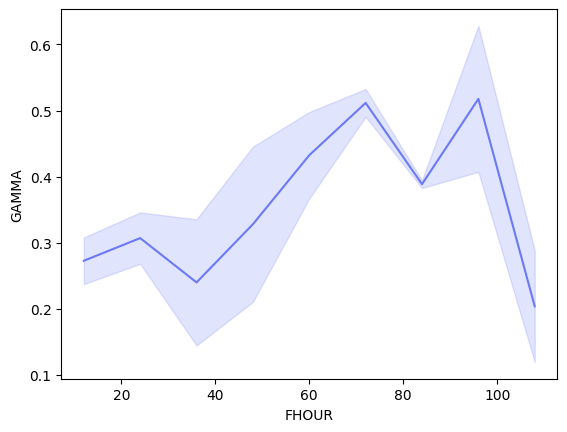

In [95]:
sns.lineplot(data=df_out,x='FHOUR',y='GAMMA')

In [96]:
RI_erly,TC_thresh_erly = get_RI_info(pdf_erly,df_in,'erly')
RI_late,TC_thresh_late = get_RI_info(pdf_late,df_in,'late')
#
RI_c_erly,TC_c_erly = get_RI_info(pdf_erly_c,df_in,'erly')
RI_c_late,TC_c_late = get_RI_info(pdf_late_c,df_in,'late')

### Wind forecasts, box plots

/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

ValueError: Length of ndarray vectors must match length of `data` when both are used, but `data` has length 9 and the vector passed to `x` has length 10.

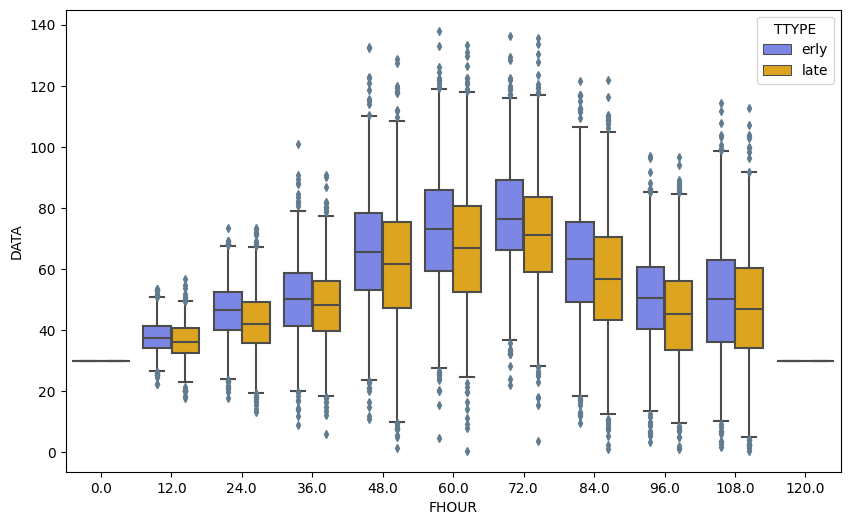

In [97]:
pal=sns.set_palette(colors)
df_box = get_boxplot_info(tcane_dist_ERLY,df_in,'erly')
df_box = df_box.mask(df_box['DATA'] < 0)
df_box_l = get_boxplot_info(tcane_dist_LATE,df_in,'late')
df_box_l = df_box_l.mask(df_box_l['DATA'] < 0)
#
df_box_ALL = pd.concat([df_box,df_box_l])
#
fig0,ax0 = plt.subplots(1,1,figsize=(10,6))
flierprops = dict(marker='d', markerfacecolor='xkcd:blue gray', markersize=4,
                  linestyle='none', markeredgecolor='xkcd:blue gray')
sns.boxplot(data=df_box_ALL,x='FHOUR',y='DATA',hue='TTYPE',palette=sns.set_palette({'xkcd:cornflower','xkcd:yellow orange'}),
            showfliers=True,flierprops=flierprops,whis=[1, 99],ax=ax0)
sns.scatterplot(data=df_in.set_index(['FHOUR']).loc[slice(12,121)],x=np.arange(0.8,9.85,1),y='VMXC',s=100,marker='v',label='TCANE Consensus')
sns.scatterplot(data=df_in.set_index(['FHOUR']).loc[slice(12,121)],x=np.arange(1.2,10.25,1),y='VMAXN',s=75,marker='s',color='xkcd:raspberry',label='NHC Official')
ax0.set_ylabel('Wind Speed (kt)',fontsize=22)
ax0.set_xlabel('Forecast Hour',fontsize=22)
ax0.set_xticks(np.arange(0,11,1),np.arange(0,121,12))
ax0.tick_params(axis='both',labelsize=14)
ax0.legend(fontsize=14)
ax0.grid()
ax0.set_title('TCANE Forecasts, {name}, {ex_date}'.format(name=df_in.iloc[0]['NAME'],ex_date=ex_date),fontsize=26)
fig0.savefig('Figures/boxplot_{name}_{exdate}.pdf'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),format='pdf',bbox_inches='tight')
fig0.savefig('Figures/boxplot_{name}_{exdate}.png'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),format='png',dpi=400,bbox_inches='tight')


### Probabilities of Cat 1, 2, etc wind speeds at each forecast time

/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

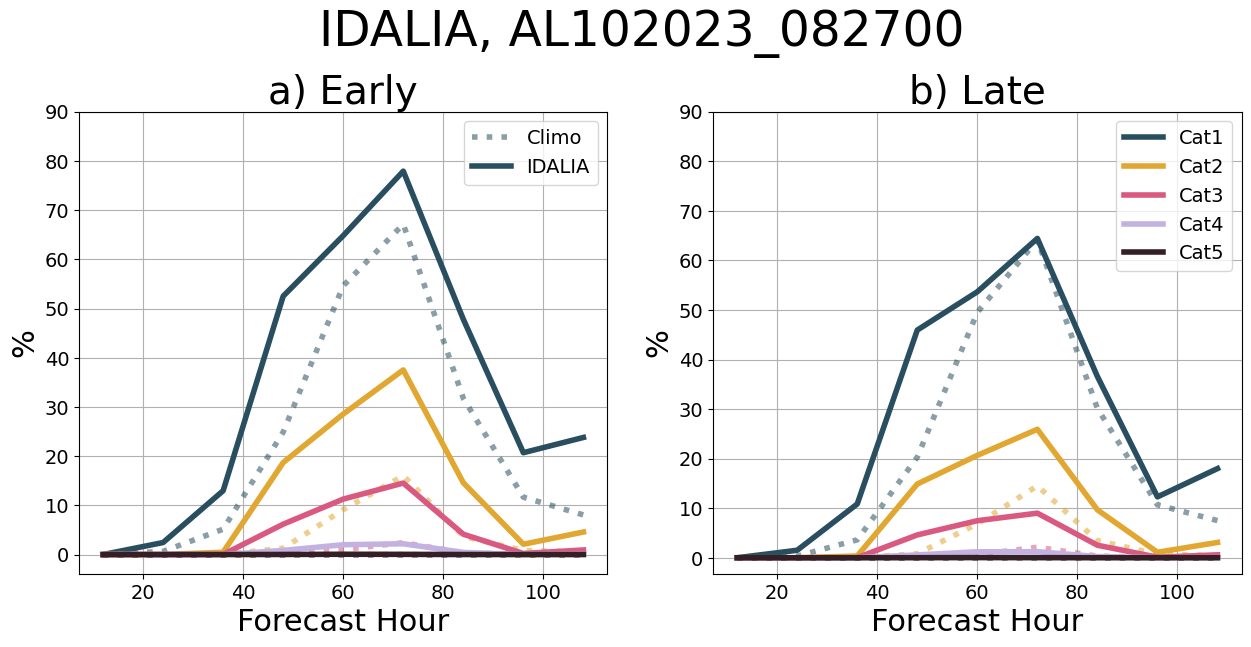

In [98]:

fig1,(ax1,ax1b) = plt.subplots(1,2,figsize=(15,6))
for i in range(1,6):
# 
    sns.lineplot(data=TC_c_erly.reset_index(),x=TC_c_erly.index,y='PCT Cat{i}'.format(i=i),color=colors[i-1],label=('Climo' if i == 1 else None),
                 alpha=0.55,linewidth=4,ax=ax1,linestyle=':')
    sns.lineplot(data=TC_c_late.reset_index(),x=TC_c_late.index,y='PCT Cat{i}'.format(i=i),color=colors[i-1],label=None,
                         alpha=0.55,linewidth=4,ax=ax1b,linestyle=':')
    #
    sns.lineplot(data=TC_thresh_erly.reset_index(),x=TC_thresh_erly.index,y='PCT Cat{i}'.format(i=i),color=colors[i-1],
                 label=('{exdate}'.format(exdate=df_in.iloc[0]['NAME']) if i == 1 else None),ax=ax1,linewidth=4)
    sns.lineplot(data=TC_thresh_late,x=TC_thresh_late.index,y='PCT Cat{i}'.format(i=i),color=colors[i-1],label='Cat{i}'.format(i=i),ax=ax1b,linewidth=4)
#

ax1.legend(fontsize=14)
ax1.grid()
ax1.set_yticks(np.arange(0,95,10))
ax1.set_ylabel('%',fontsize=22)
ax1.set_xlabel('Forecast Hour',fontsize=22)
ax1.tick_params(axis='both',labelsize=14)
ax1.set_title('a) Early',fontsize=28)
#
ax1b.legend(fontsize=14)
ax1b.grid()
ax1b.set_yticks(np.arange(0,95,10))
ax1b.set_ylabel('%',fontsize=22)
ax1b.set_xlabel('Forecast Hour',fontsize=22)
ax1b.tick_params(axis='both',labelsize=14)
ax1b.set_title('b) Late',fontsize=28)
#
fig1.suptitle('{name}, {exdate}'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),fontsize=35,y=1.05)
fig1.savefig('Figures/pr_cat_{name}_{exdate}.pdf'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),format='pdf',bbox_inches='tight')
fig1.savefig('Figures/pr_cat_{name}_{exdate}.png'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),format='png',dpi=400,bbox_inches='tight')


#### Probability of RI

/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

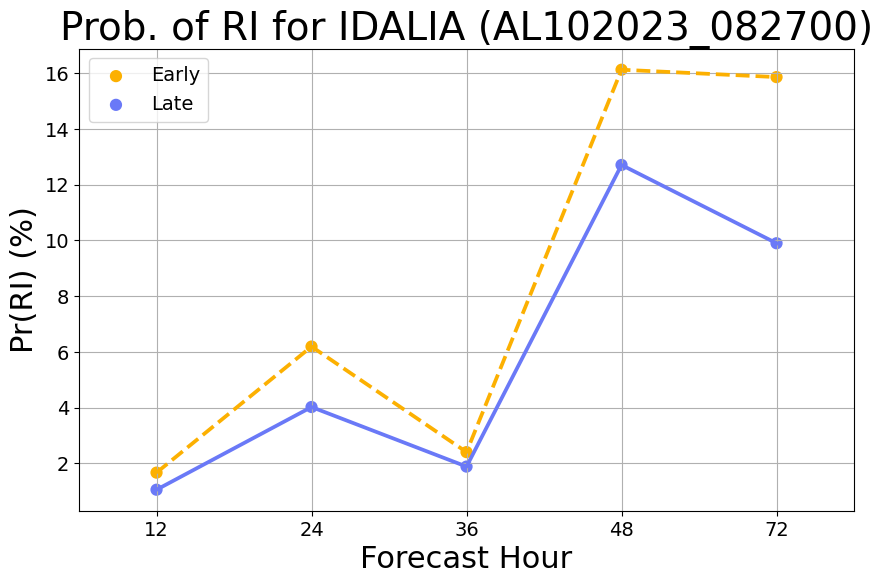

In [68]:
fig2,ax2 = plt.subplots(1,1,figsize=(10,6))
sns.pointplot(data=RI_erly,x=RI_erly.index,y='PCT RI',color='xkcd:yellow orange',ax=ax2,label='Early')
ax2l = sns.pointplot(data=RI_late,x=RI_late.index,y='PCT RI',color='xkcd:cornflower',ax=ax2,label='Late')
ax2l.lines[0].set_linestyle('--')
ax2.legend(fontsize=14)
ax2.grid()
ax2.set_ylabel('Pr(RI) (%)',fontsize=22)
ax2.set_xlabel('Forecast Hour',fontsize=22)
ax2.tick_params(axis='both',labelsize=14)
ax2.set_title('Prob. of RI for {name} ({exdate})'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),fontsize=28)
fig2.savefig('Figures/pr_RI_{name}_{exdate}.pdf'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),format='pdf',bbox_inches='tight')
fig2.savefig('Figures/pr_RI_{name}_{exdate}.png'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),format='png',dpi=400,bbox_inches='tight')


In [69]:
RI_thresh = {12:20,
             24:30,
             36:45,
             48:55,
             72:65}
edeck_trim = edeck_all[(edeck_all['TAU'].isin(list(RI_thresh.keys()))) & (edeck_all['d_I'].isin(list(RI_thresh.values())))]
edeck_trim['FHOUR'] = edeck_trim['TAU']
edeck_trim = edeck_trim.set_index(['FHOUR'])

Same as above but with edeck info

/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

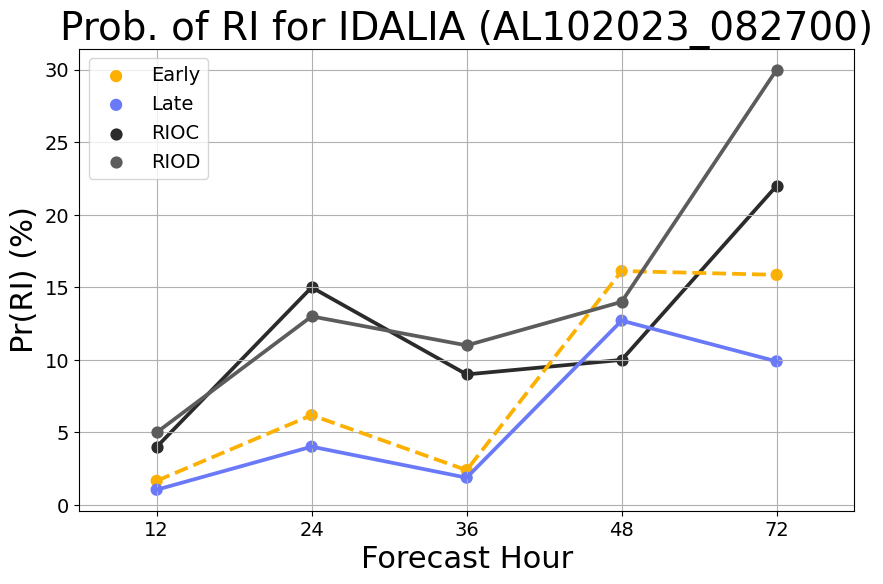

In [70]:
fig22,ax22 = plt.subplots(1,1,figsize=(10,6))
sns.pointplot(data=RI_erly,x=RI_erly.index,y='PCT RI',color='xkcd:yellow orange',ax=ax22,label='Early')
ax22l = sns.pointplot(data=RI_late,x=RI_late.index,y='PCT RI',color='xkcd:cornflower',ax=ax22,label='Late')
ax22e = sns.pointplot(data=edeck_trim,x=edeck_trim.index,y='Prob(RI)',hue='Technique',palette=sns.color_palette('Greys_r'),ax=ax22,label='edeck')
ax22e.lines[0].set_linestyle('--')
ax22.legend(fontsize=14)
ax22.grid()
ax22.set_ylabel('Pr(RI) (%)',fontsize=22)
ax22.set_xlabel('Forecast Hour',fontsize=22)
ax22.tick_params(axis='both',labelsize=14)
ax22.set_title('Prob. of RI for {name} ({exdate})'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),fontsize=28)
fig22.savefig('Figures/pr_RI_{name}_{exdate}_with_edeck.pdf'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),format='pdf',bbox_inches='tight')
fig22.savefig('Figures/pr_RI_{name}_{exdate}_with_edeck.png'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),format='png',dpi=400,bbox_inches='tight')


### 90-10th, 75-25th pctile

In [71]:
df_pct = get_pctiles(tcane_dist_ERLY,'erly')
df_pct_l = get_pctiles(tcane_dist_LATE,'late')
df_pct.loc[0,['P1','P5','P10','P25','P50','P75','P90','P95','P99']] = df_in.loc[0]['VMAX0']
df_pct_l.loc[0,['P1','P5','P10','P25','P50','P75','P90','P95','P99']] = df_in.loc[0]['VMAX0']

/tmp/ipykernel_2853988/727729655.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pct_ALL = pd.concat([df_pct_ALL,df_pct])
/tmp/ipykernel_2853988/727729655.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pct_ALL = pd.concat([df_pct_ALL,df_pct])
/tmp/ipykernel_2853988/727729655.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result 

/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

<Axes: ylabel='DIFF+'>

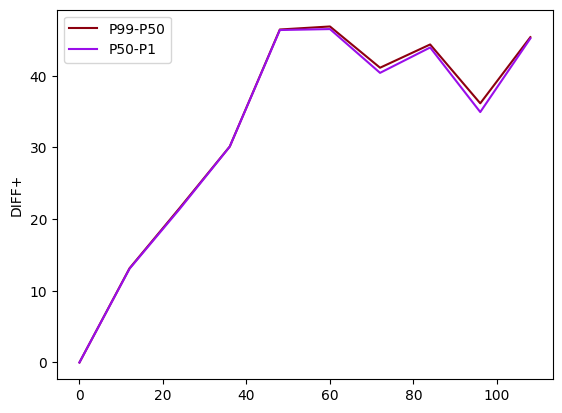

In [72]:
df_pct['DIFF+'] = df_pct['P99']-df_pct['P50']
df_pct['DIFF-'] = df_pct['P50']-df_pct['P1']
#sns.lineplot(data=df_pct,x=df_pct.index,y='P1')
#sns.lineplot(data=df_pct,x=df_pct.index,y='P99')
sns.lineplot(data=df_pct,x=df_pct.index,y='DIFF+',color='xkcd:crimson',label='P99-P50')
sns.lineplot(data=df_pct,x=df_pct.index,y='DIFF-',color='xkcd:violet',label='P50-P1')


/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

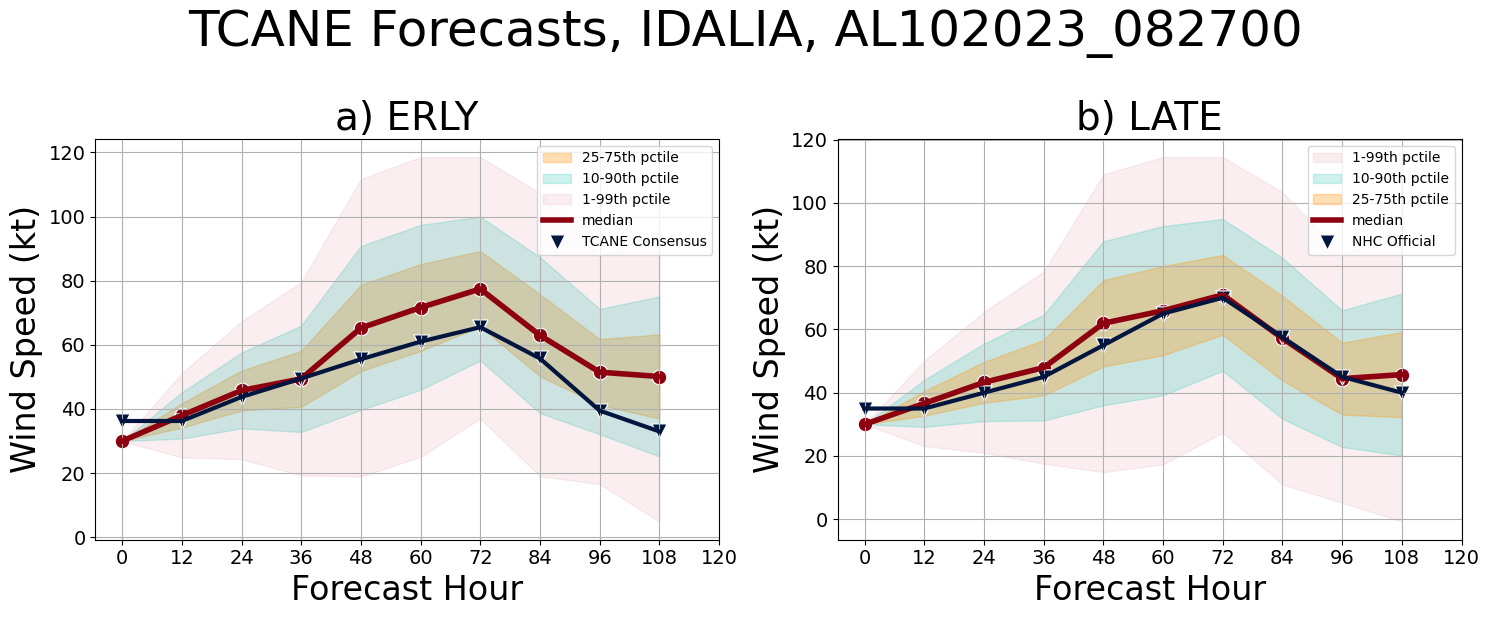

In [73]:
fig3,(ax3,ax3b) = plt.subplots(1,2,figsize=(15,6))
df_in_plt = df_in.set_index(['FHOUR']).loc[slice(0,121)].reset_index()
# Add 0
df_in_plt.loc[10] = df_in_plt.iloc[0]
df_in_plt.loc[10,'FHOUR'] = 0
ax3.fill_between(df_pct.index,df_pct['P25'],df_pct['P75'],color='xkcd:tangerine',alpha=0.3,label='25-75th pctile')
ax3.fill_between(df_pct.index,df_pct['P10'],df_pct['P90'],color='xkcd:turquoise',alpha=0.2,label='10-90th pctile')
ax3.fill_between(df_pct.index,df_pct['P1'],df_pct['P99'],color='xkcd:rose',alpha=0.1,label='1-99th pctile')
sns.lineplot(data=df_pct,x=df_pct.index,y=df_pct['P50'],label='median',color='xkcd:crimson',linewidth=4,ax=ax3)
sns.scatterplot(data=df_pct,x=df_pct.index,y=df_pct['P50'],label=None,color='xkcd:crimson',s=110,ax=ax3)
sns.lineplot(data=df_in_plt,x='FHOUR',y='VMXC',color='xkcd:navy',linewidth=3,ax=ax3)
sns.scatterplot(data=df_in_plt,x='FHOUR',y='VMXC',color='xkcd:navy',s=120,marker='v',label='TCANE Consensus',ax=ax3)
#ax3.set_ylim([10,120])
ax3.grid()
ax3.set_xticks(np.arange(0,121,12))
ax3.set_xticklabels(np.arange(0,121,12))
ax3.set_ylabel('Wind Speed (kt)',fontsize=24)
ax3.tick_params(axis='both',labelsize=14)
ax3.set_xlabel('Forecast Hour',fontsize=24)
ax3.set_title('a) ERLY',fontsize=28)
#
ax3b.fill_between(df_pct_l.index,df_pct_l['P1'],df_pct_l['P99'],color='xkcd:rose',alpha=0.1,label='1-99th pctile')
ax3b.fill_between(df_pct_l.index,df_pct_l['P10'],df_pct_l['P90'],color='xkcd:turquoise',alpha=0.2,label='10-90th pctile')
ax3b.fill_between(df_pct_l.index,df_pct_l['P25'],df_pct_l['P75'],color='xkcd:tangerine',alpha=0.3,label='25-75th pctile')
sns.lineplot(data=df_pct_l,x=df_pct_l.index,y=df_pct_l['P50'],label='median',color='xkcd:crimson',linewidth=4,ax=ax3b)
sns.scatterplot(data=df_pct_l,x=df_pct_l.index,y=df_pct_l['P50'],label=None,color='xkcd:crimson',s=110,ax=ax3b)
sns.lineplot(data=df_in_plt,x='FHOUR',y='VMAXN',color='xkcd:navy',linewidth=3,ax=ax3b)
sns.scatterplot(data=df_in_plt,x='FHOUR',y='VMAXN',color='xkcd:navy',s=120,marker='v',label='NHC Official',ax=ax3b)
#
#ax3b.set_ylim([10,120])
ax3b.grid()
ax3b.set_xticks(np.arange(0,121,12))
ax3b.set_xticklabels(np.arange(0,121,12))
ax3b.set_ylabel('Wind Speed (kt)',fontsize=24)
ax3b.tick_params(axis='both',labelsize=14)
ax3b.set_xlabel('Forecast Hour',fontsize=24)
ax3b.set_title('b) LATE',fontsize=28)
#
fig3.suptitle('TCANE Forecasts, {name}, {ex_date}'.format(name=df_in.iloc[0]['NAME'],ex_date=ex_date),fontsize=36,y=1.02)
fig3.tight_layout()
fig3.savefig('Figures/p10-90_{name}_{exdate}.pdf'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),format='pdf',bbox_inches='tight')
fig3.savefig('Figures/p10-90_{name}_{exdate}.png'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),format='png',dpi=400,bbox_inches='tight')


Same as above but with best tracks

/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mcgraw/miniconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

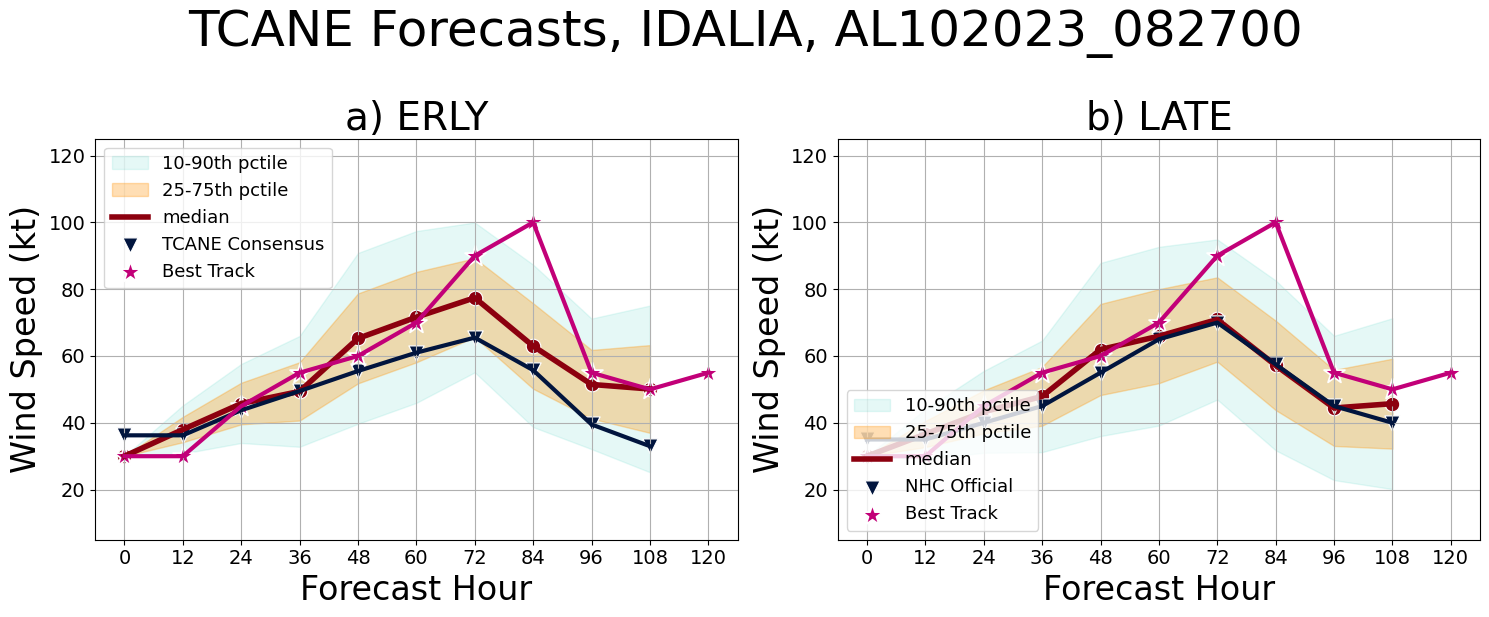

In [74]:
fig3,(ax3,ax3b) = plt.subplots(1,2,figsize=(15,6))
ax3.fill_between(df_pct.index,df_pct['P10'],df_pct['P90'],color='xkcd:turquoise',alpha=0.1,label='10-90th pctile')
ax3.fill_between(df_pct.index,df_pct['P25'],df_pct['P75'],color='xkcd:tangerine',alpha=0.3,label='25-75th pctile')
sns.lineplot(data=df_pct,x=df_pct.index,y=df_pct['P50'],label='median',color='xkcd:crimson',linewidth=4,ax=ax3)
sns.scatterplot(data=df_pct,x=df_pct.index,y=df_pct['P50'],label=None,color='xkcd:crimson',s=110,ax=ax3)
sns.lineplot(data=df_in_plt,x='FHOUR',y='VMXC',color='xkcd:navy',linewidth=3,ax=ax3)
sns.scatterplot(data=df_in_plt,x='FHOUR',y='VMXC',color='xkcd:navy',s=120,marker='v',label='TCANE Consensus',ax=ax3)
sns.lineplot(data=b_deck_trim,x='FHOUR',y='VMAX',color='xkcd:magenta',linewidth=3,label=None,ax=ax3)
sns.scatterplot(data=b_deck_trim,x='FHOUR',y='VMAX',color='xkcd:magenta',s=250,marker='*',label='Best Track',ax=ax3)
ax3.set_ylim([5,125])
ax3.grid()
ax3.set_xticks(np.arange(0,121,12))
ax3.set_xticklabels(np.arange(0,121,12))
ax3.set_ylabel('Wind Speed (kt)',fontsize=24)
ax3.tick_params(axis='both',labelsize=14)
ax3.set_xlabel('Forecast Hour',fontsize=24)
ax3.set_title('a) ERLY',fontsize=28)
ax3.legend(fontsize=13)
#
ax3b.fill_between(df_pct_l.index,df_pct_l['P10'],df_pct_l['P90'],color='xkcd:turquoise',alpha=0.1,label='10-90th pctile')
ax3b.fill_between(df_pct_l.index,df_pct_l['P25'],df_pct_l['P75'],color='xkcd:tangerine',alpha=0.3,label='25-75th pctile')
sns.lineplot(data=df_pct_l,x=df_pct_l.index,y=df_pct_l['P50'],label='median',color='xkcd:crimson',linewidth=4,ax=ax3b)
sns.scatterplot(data=df_pct_l,x=df_pct_l.index,y=df_pct_l['P50'],label=None,color='xkcd:crimson',s=110,ax=ax3b)
sns.lineplot(data=df_in_plt,x='FHOUR',y='VMAXN',color='xkcd:navy',linewidth=3,ax=ax3b)
sns.scatterplot(data=df_in_plt,x='FHOUR',y='VMAXN',color='xkcd:navy',s=120,marker='v',label='NHC Official',ax=ax3b)
sns.lineplot(data=b_deck_trim,x='FHOUR',y='VMAX',color='xkcd:magenta',linewidth=3,label=None,ax=ax3b)
sns.scatterplot(data=b_deck_trim,x='FHOUR',y='VMAX',color='xkcd:magenta',s=250,marker='*',label='Best Track',ax=ax3b)
#
ax3b.set_ylim([5,125])
ax3b.grid()
ax3b.set_xticks(np.arange(0,121,12))
ax3b.set_xticklabels(np.arange(0,121,12))
ax3b.set_ylabel('Wind Speed (kt)',fontsize=24)
ax3b.tick_params(axis='both',labelsize=14)
ax3b.set_xlabel('Forecast Hour',fontsize=24)
ax3b.set_title('b) LATE',fontsize=28)
ax3b.legend(fontsize=13,loc='lower left')
#
fig3.suptitle('TCANE Forecasts, {name}, {ex_date}'.format(name=df_in.iloc[0]['NAME'],ex_date=ex_date),fontsize=36,y=1.02)
fig3.tight_layout()
#
fig3.savefig('Figures/p10-90_{name}_{exdate}_with_BTR.pdf'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),format='pdf',bbox_inches='tight')
fig3.savefig('Figures/p10-90_{name}_{exdate}_with_BTR.png'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),format='png',dpi=400,bbox_inches='tight')


In [30]:
bdt = b_deck_trim.set_index(['FHOUR'])
bdt['Vdiff'] = -bdt['VMAX'].shift(1) + bdt['VMAX']
bdt['Vdiff24'] = -bdt['VMAX'].shift(2) + bdt['VMAX']
bdt['Vdiff36'] = -bdt['VMAX'].shift(3) + bdt['VMAX']
#tick_labels = [bdt.reset_index()['FHOUR'].iloc[i],bdt['DATE'].dt.strftime('%Y-%m-%d-%H').iloc[i]] for i in np.arange(0,len(bdt))]
hr_list = bdt.reset_index()['FHOUR'].astype(int).astype(str).tolist()
hr_list = ["\n"+hr+" hr" for hr in hr_list]
hr_list

['\n0 hr',
 '\n12 hr',
 '\n24 hr',
 '\n36 hr',
 '\n48 hr',
 '\n60 hr',
 '\n72 hr',
 '\n84 hr',
 '\n96 hr',
 '\n108 hr',
 '\n120 hr']

In [31]:
new_labels = [''.join(x) for x in zip(bdt['DATE'].dt.strftime('%Y-%m-%d-%H'),hr_list)]

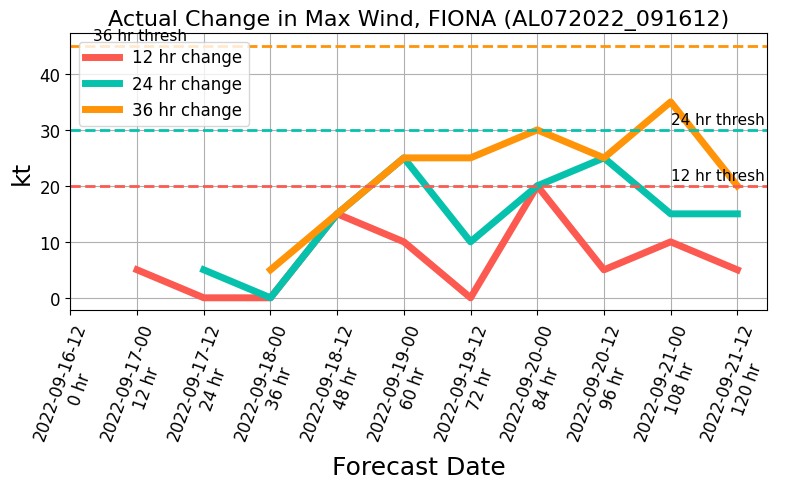

In [32]:
fig1,ax1 = plt.subplots(1,1,figsize=(8,5))
sns.lineplot(data=bdt,x=bdt.index,y=bdt.Vdiff,color='xkcd:coral',linewidth=5,label='12 hr change')
sns.lineplot(data=bdt,x=bdt.index,y=bdt.Vdiff24,color='xkcd:turquoise',linewidth=5,label='24 hr change')
sns.lineplot(data=bdt,x=bdt.index,y=bdt.Vdiff36,color='xkcd:tangerine',linewidth=5,label='36 hr change')
ax1.axhline(RI_thresh[12],color='xkcd:coral',linewidth=2,linestyle='--',label=None)
ax1.axhline(RI_thresh[24],color='xkcd:turquoise',linewidth=2,linestyle='--',label=None)
ax1.axhline(RI_thresh[36],color='xkcd:tangerine',linewidth=2,linestyle='--',label=None)
ax1.text(108,RI_thresh[12]+1,'12 hr thresh',fontsize=11)
ax1.text(108,RI_thresh[24]+1,'24 hr thresh',fontsize=11)
ax1.text(4,RI_thresh[36]+1,'36 hr thresh',fontsize=11)
ax1.set_xticks(bdt.index,new_labels,rotation=70)
ax1.set_ylabel('kt',fontsize=18)
ax1.grid()
# ax1.set_ylim([0,55])
ax1.legend(fontsize=12)
ax1.set_xlabel('Forecast Date',fontsize=18)
ax1.tick_params(axis='both',labelsize=12)
ax1.set_title('Actual Change in Max Wind, {name} ({ex_date})'.format(name=df_in.iloc[0]['NAME'],ex_date=ex_date),fontsize=16)
fig1.tight_layout()
fig1.savefig('Figures/12hr-change-best-tracks_{name}_{exdate}.pdf'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),format='pdf',bbox_inches='tight')
fig1.savefig('Figures/12hr-change-best-tracks_{name}_{exdate}.png'.format(name=df_in.iloc[0]['NAME'],exdate=ex_date),format='png',dpi=400,bbox_inches='tight')


/tmp/ipykernel_2210645/2282973580.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  old = df_box.set_index(['TTYPE','FHOUR']).xs(('erly',hr))


<Axes: >

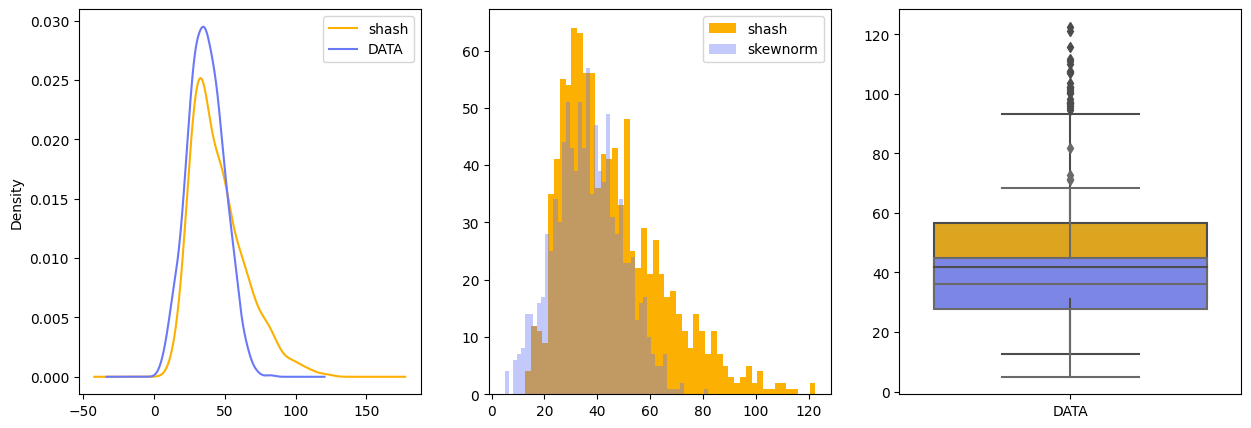

In [186]:
size = 10000
hr = 108
dtest = df_out.set_index(['TTYPE','FHOUR']).xs('erly').xs(hr)
dist = tcane_dist_ERLY.xs(hr)
Z = sps.norm.rvs(size=1000)
Y =  dist['DIST'][0] + dist['DIST'][1] * np.sinh((np.arcsinh(Z) + dist['DIST'][2]) / 1)
Yy = pd.Series(Y)
old = df_box.set_index(['TTYPE','FHOUR']).xs(('erly',hr))
# plt.hist(Y,bins=50,label='shash')
fig1,(ax1,ax1b,ax1c) = plt.subplots(1,3,figsize=(15,5))
Yy.plot.density(ax=ax1,label='shash')
old.plot.density(ax=ax1,label='skewnorm')
ax1.legend()
ax1b.hist(Y,bins=50,label='shash')
ax1b.hist(old,bins=50,label='skewnorm',alpha=0.4)
ax1b.legend()
#
sns.boxplot(data=Yy,ax=ax1c)
sns.boxplot(data=old,ax=ax1c,color='xkcd:cornflower')